# **Análisis de la Accidentalidad Vial en Madrid**


El presente estudio analiza el conjunto de datos sobre la accidentalidad vial registrada en la ciudad de Madrid. La información ha sido obtenida del Portal de [Datos Abiertos del Ayuntamiento de Madrid](https://datos.madrid.es/portal/site/egob/menuitem.c05c1f754a33a9fbe4b2e4b284f1a5a0/?vgnextoid=7c2843010d9c3610VgnVCM2000001f4a900aRCRD&vgnextchannel=374512b9ace9f310VgnVCM100000171f5a0aRCRD&vgnextfmt=default), una fuente oficial que garantiza la fiabilidad y precisión de los datos.


Este conjunto de datos fue seleccionado por su alto nivel de detalle, ya que la riqueza de sus variables, que incluyen localización, factores temporales, condiciones atmosféricas y tipología de vehículos, ofrece una notable oportunidad para realizar un análisis multidimensional. A partir de este, el objetivo principal es la identificación de patrones y factores contribuyentes a dichos incidentes.


**Mediante la visualización de datos, se pretende dar respuesta a las siguientes cuestiones:**

*   ¿Qué distritos presentan la mayor frecuencia de siniestros?

*   ¿Qué franja horaria representa un mayor riesgo para los conductores?

*   ¿Qué relación existe entre las condiciones meteorológicas y la ocurrencia de accidentes?

*   ¿Qué tipología de vehículos se ve más comúnmente implicada?


El propósito es emplear estas visualizaciones para construir una narrativa sobre la seguridad vial en la ciudad y extraer conclusiones fundamentadas, conforme a los requisitos del análisis.


In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import folium
import json

df = pd.read_csv("2025_Accidentalidad (1).csv", delimiter=';')


df['fecha'] = pd.to_datetime(df['fecha'], dayfirst=True)
df['hora'] = pd.to_datetime(df['hora'], format='%H:%M:%S').dt.hour

df['distrito'] = df['distrito'].str.strip()

accidents_by_district = df['distrito'].value_counts().reset_index()
accidents_by_district.columns = ['distrito', 'num_accidents']

**Finding 1: Identificación de Focos Geográficos de Siniestralidad**

Para comprender la concentración geográfica de los accidentes, se ha generado un mapa coroplético que ofrece una visión general intuitiva de la distribución de la siniestralidad en los distritos de Madrid.


In [42]:
import pandas as pd
import json
import folium

df = pd.read_csv("2025_Accidentalidad (1).csv", delimiter=';')

df.columns = df.columns.str.strip()

df['distrito'] = df['distrito'].str.strip()


# Standardize District Names (The Fix)
district_mapping = {
    'ARGANZUELA': 'Arganzuela',
    'BARAJAS': 'Barajas',
    'CARABANCHEL': 'Carabanchel',
    'CENTRO': 'Centro',
    'CHAMARTIN': 'Chamartín',
    'CHAMBERI': 'Chamberí',
    'CIUDAD LINEAL': 'Ciudad Lineal',
    'FUENCARRAL-EL PARDO': 'Fuencarral-El Pardo',
    'HORTALEZA': 'Hortaleza',
    'LATINA': 'Latina',
    'MONCLOA-ARAVACA': 'Moncloa-Aravaca',
    'MORATALAZ': 'Moratalaz',
    'PUENTE DE VALLECAS': 'Puente de Vallecas',
    'RETIRO': 'Retiro',
    'SALAMANCA': 'Salamanca',
    'SAN BLAS': 'San Blas-Canillejas',
    'TETUAN': 'Tetuán',
    'USERA': 'Usera',
    'VICALVARO': 'Vicálvaro',
    'VILLA DE VALLECAS': 'Villa de Vallecas',
    'VILLAVERDE': 'Villaverde',
    'SAN BLAS-CANILLEJAS': 'San Blas-Canillejas'
}

df['distrito'] = df['distrito'].apply(lambda x: district_mapping.get(x, x))


# Aggregate Data and Create Map
accidents_by_district = df['distrito'].value_counts().reset_index()
accidents_by_district.columns = ['distrito', 'num_accidents']

# GeoJSON file
try:
    with open('madrid-districts (1).geojson', 'r', encoding='utf-8') as f:
        madrid_geojson = json.load(f)
except FileNotFoundError:
    print("Error: 'madrid-districts (1).geojson' not found.")
    print("Please ensure the file is in the same directory as your notebook.")
    madrid_geojson = None

if madrid_geojson:
    m = folium.Map(location=[40.4168, -3.7038], zoom_start=11, tiles="CartoDB positron")

    folium.Choropleth(
        geo_data=madrid_geojson,
        name='choropleth',
        data=accidents_by_district,
        columns=['distrito', 'num_accidents'],
        key_on='feature.properties.name',
        fill_color='YlOrRd',
        fill_opacity=0.8,
        line_opacity=0.3,
        legend_name='Number of Accidents'
    ).add_to(m)

    folium.LayerControl().add_to(m)

    display(m)

El mapa coroplético ilustra de manera clara que la distribución de la siniestralidad no es uniforme. Las áreas con sombreado más oscuro, indicativas de una mayor incidencia, se concentran en zonas específicas. **Los distritos de Puente de Vallecas, Carabanchel y Salamanca** emergen como focos de alta concentración de incidentes.


Para enfatizar la proporcionalidad de los accidentes en estos distritos clave, se utiliza un gráfico de treemap. Este formato visualiza la división del número total de siniestros, donde el área de cada rectángulo es proporcional a su contribución al total.

In [43]:
fig = px.treemap(accidents_by_district,
                 path=['distrito'],
                 values='num_accidents',
                 title='Proportional View of Accidents per District (Treemap)',
                 color='num_accidents',
                 color_continuous_scale='Reds')
fig.show()

Esta visualización confirma los hallazgos del mapa: **Puente de Vallecas** y **Carabanchel** ocupan las áreas de mayor tamaño, reforzando su condición de distritos con la frecuencia más elevada de accidentes. La concentración de iniciativas de seguridad vial en estas áreas de alto riesgo podría representar la estrategia más eficaz para la ciudad.

**Findings 2: Picos de Siniestralidad en Horas Punta**

El análisis de la distribución horaria de los accidentes revela un patrón claro y predecible vinculado a los desplazamientos diarios.

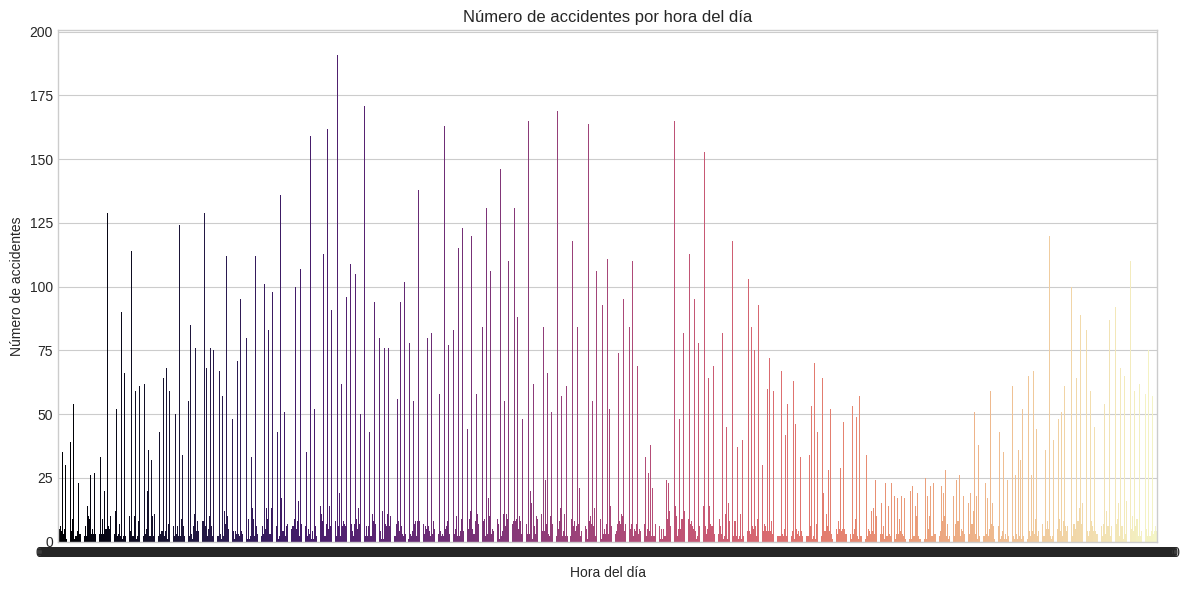

In [44]:
hourly_counts = df['hora'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
sns.barplot(x=hourly_counts.index, y=hourly_counts.values, palette='magma', hue=hourly_counts.index, legend=False)


plt.title('Número de accidentes por hora del día')
plt.xlabel('Hora del día')
plt.ylabel('Número de accidentes')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

El histograma muestra dos picos definidos. El primero se produce coincidiendo con el desplazamiento matutino (en torno a las 9:00 h), y un segundo pico, más pronunciado, en las horas de la tarde (entre las 19:00 y 20:00 h). Este patrón se correlaciona directamente con las horas punta de la ciudad, periodos en los que el volumen de tráfico alcanza su máxima intensidad.


**Finding 3: Prevalencia de Factores Humanos sobre los Ambientales**

Esta visualización desafía la suposición común de que las condiciones meteorológicas adversas son la causa principal de los accidentes. Los datos demuestran de forma concluyente que la gran mayoría de los siniestros ocurren en condiciones de cielo "**Despejado**".

/tmp/ipython-input-45-2818579080.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




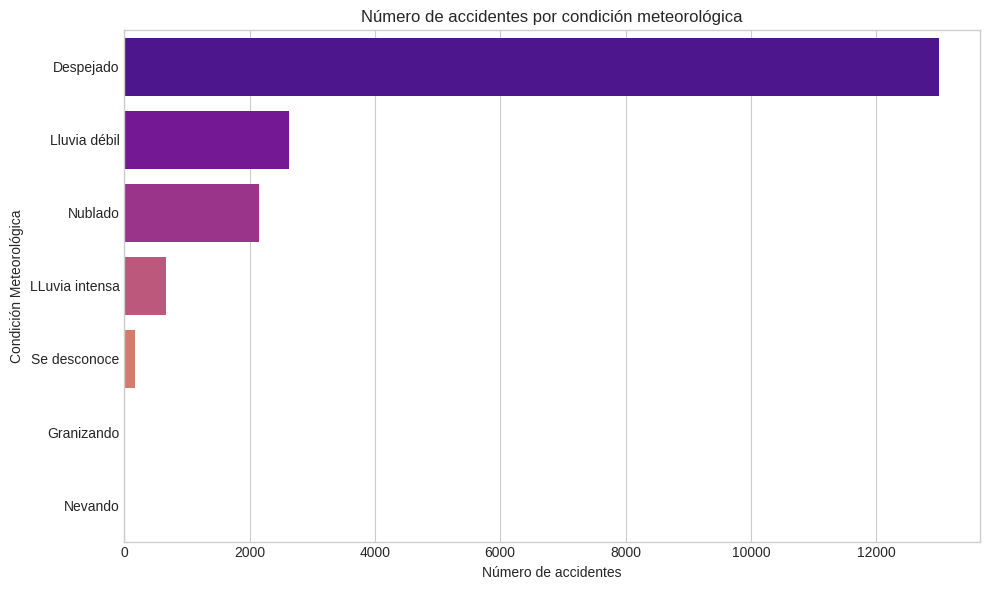

In [45]:
plt.figure(figsize=(10, 6))
sns.countplot(y='estado_meteorológico', data=df, order = df['estado_meteorológico'].value_counts().index, palette='plasma')
plt.title('Número de accidentes por condición meteorológica')
plt.xlabel('Número de accidentes')
plt.ylabel('Condición Meteorológica')
plt.tight_layout()
plt.show()

Este es un hallazgo crucial: sugiere que los factores ambientales, como la lluvia o la nieve, son menos significativos que los factores humanos, tales como el error del conductor, la distracción o el exceso de velocidad, los cuales son más prevalentes en condiciones de conducción típicas.



**Finding 4: Tipología de Vehículos Involucrados**


Como es previsible, **los "Turismos" (coches de pasajeros)** son el tipo de vehículo con mayor implicación en accidentes, lo cual es coherente con su predominancia en el parque móvil.

No obstante, es relevante señalar que las motocicletas, furgonetas y todoterrenos también presentan una representatividad significativa. Esto subraya que el riesgo no se limita a una única tipología de vehículo y que las medidas de seguridad deben considerar la diversidad del parque circulante de Madrid.


/tmp/ipython-input-46-3114134669.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




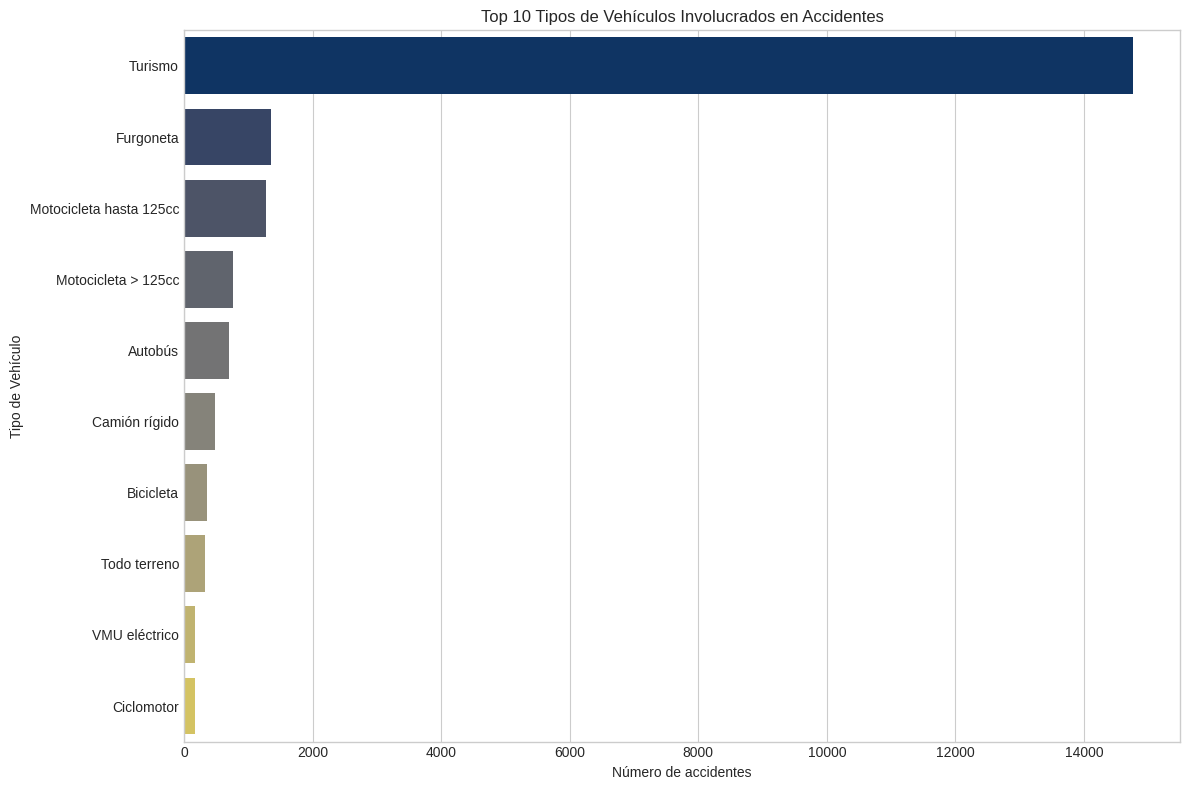

In [46]:
plt.figure(figsize=(12, 8))
sns.countplot(y='tipo_vehiculo', data=df, order = df['tipo_vehiculo'].value_counts().head(10).index, palette='cividis')
plt.title('Top 10 Tipos de Vehículos Involucrados en Accidentes')
plt.xlabel('Número de accidentes')
plt.ylabel('Tipo de Vehículo')
plt.tight_layout()
plt.show()

**Conclusiones**


El análisis de los datos de accidentalidad de Madrid ofrece varias conclusiones clave para la comprensión de la seguridad vial en la ciudad:



1. **El factor geográfico es determinante:** La distribución de accidentes no es homogénea en el territorio urbano. Los distritos de **Puente de Vallecas y Carabanchel **constituyen focos de alta siniestralidad que requieren intervenciones de seguridad focalizadas.


2. **Prevalencia del factor humano sobre el ambiental:** El factor más influyente en la siniestralidad parece ser el comportamiento del conductor, por encima de las condiciones meteorológicas. El hecho de que la mayoría de los incidentes ocurran en **días despejados** y durante **las horas de máxima afluencia** apunta a la congestión del tráfico y al error humano como las causas primarias.


3. **Patrones temporales predecibles: **Los accidentes alcanzan sus picos de forma predecible durante los desplazamientos de la mañana y la tarde, lo que confirma la correlación directa entre un mayor volumen de tráfico y un mayor riesgo de siniestralidad.



En resumen, **bold text** los datos presentan una narrativa que desafía ciertas asunciones comunes y ofrece una dirección clara para la implementación de mejoras en la seguridad vial: focalizar los recursos en los distritos de alto riesgo y desarrollar estrategias para mitigar los desafíos del tráfico en horas punta. Este enfoque cumple con el requisito central de la tarea de extraer conocimiento significativo a partir de la visualización de datos.
